# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [4]:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [7]:
sensor.dropna()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299
...,...,...,...,...,...,...,...,...,...,...,...,...
1746,1.797120,-0.562324,2.445889,0.824443,0.533154,0.189844,-0.123211,0.909536,-0.379757,-0.268367,0.006733,-0.064874
1747,1.814297,-0.569719,2.449655,0.817212,0.539396,0.203020,-0.057641,0.723118,-0.437812,-0.102444,-0.060666,-0.229738
1748,1.830821,-0.578367,2.447967,0.809207,0.546658,0.215288,0.343238,0.997236,-0.338155,-0.085590,-0.030209,-0.087740
1749,1.849557,-0.586962,2.439458,0.800485,0.553834,0.229110,0.470144,1.227937,-0.332223,-0.048105,0.029555,0.060441


How many rows and columns are in our data?

In [9]:
sensor.shape


(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [26]:
start_date = "2018-01-01 00:00:00"
end_date = "2018-01-01 00:29:10"

number_of_periods = len(sensor)

time_series_index = pd.date_range(start=start_date, end=end_date, periods=number_of_periods)

sensor.index = time_series_index

Assign the time series index to the dataframe's index.

In [27]:
sensor.set_index(time_series_index, inplace=True)

In [30]:
sensor

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 00:29:06,1.797120,-0.562324,2.445889,0.824443,0.533154,0.189844,-0.123211,0.909536,-0.379757,-0.268367,0.006733,-0.064874
2018-01-01 00:29:07,1.814297,-0.569719,2.449655,0.817212,0.539396,0.203020,-0.057641,0.723118,-0.437812,-0.102444,-0.060666,-0.229738
2018-01-01 00:29:08,1.830821,-0.578367,2.447967,0.809207,0.546658,0.215288,0.343238,0.997236,-0.338155,-0.085590,-0.030209,-0.087740
2018-01-01 00:29:09,1.849557,-0.586962,2.439458,0.800485,0.553834,0.229110,0.470144,1.227937,-0.332223,-0.048105,0.029555,0.060441


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

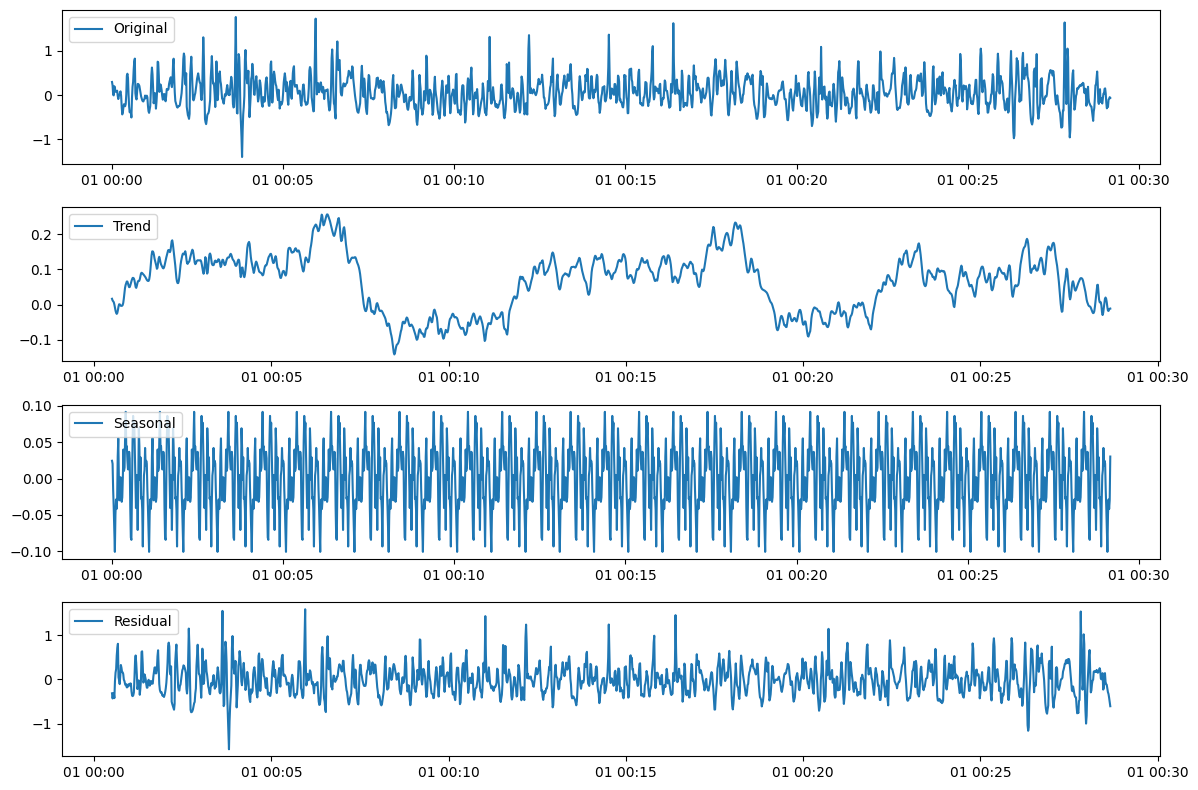

In [36]:
decomposition = seasonal_decompose(sensor['userAcceleration.x'], period=60)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(sensor['userAcceleration.x'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

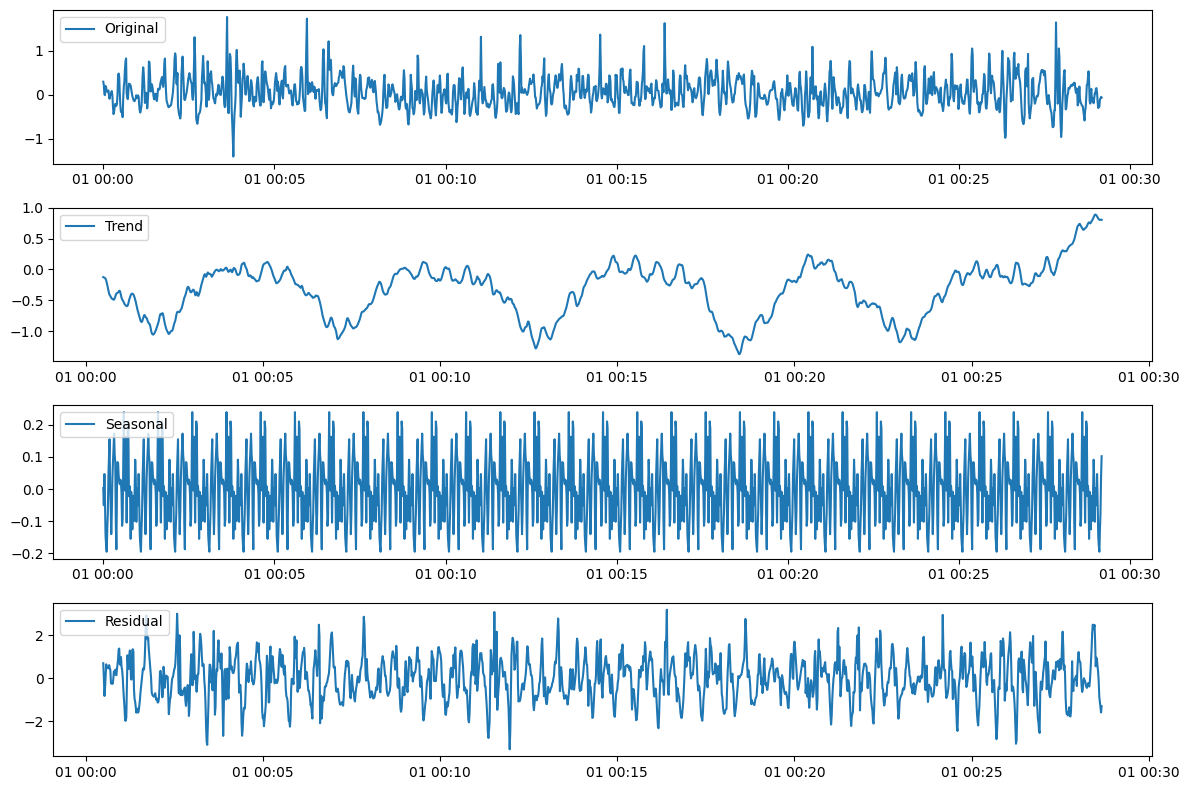

In [35]:
decomposition = seasonal_decompose(sensor['rotationRate.x'], period=60)

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(sensor['userAcceleration.x'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

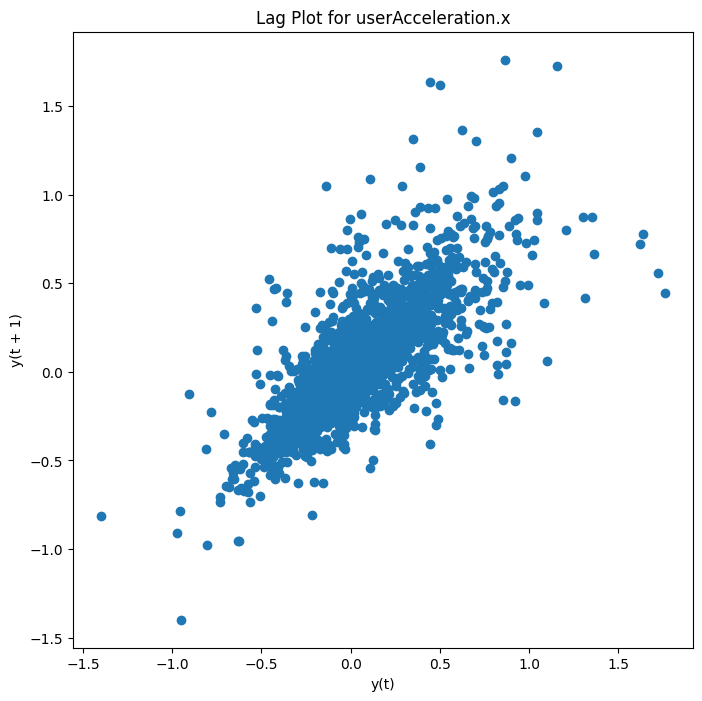

In [38]:
plt.figure(figsize=(8, 8))
lag_plot(sensor['userAcceleration.x'])
plt.title("Lag Plot for userAcceleration.x")
plt.show()


Create a lag plot for `rotationRate.x`

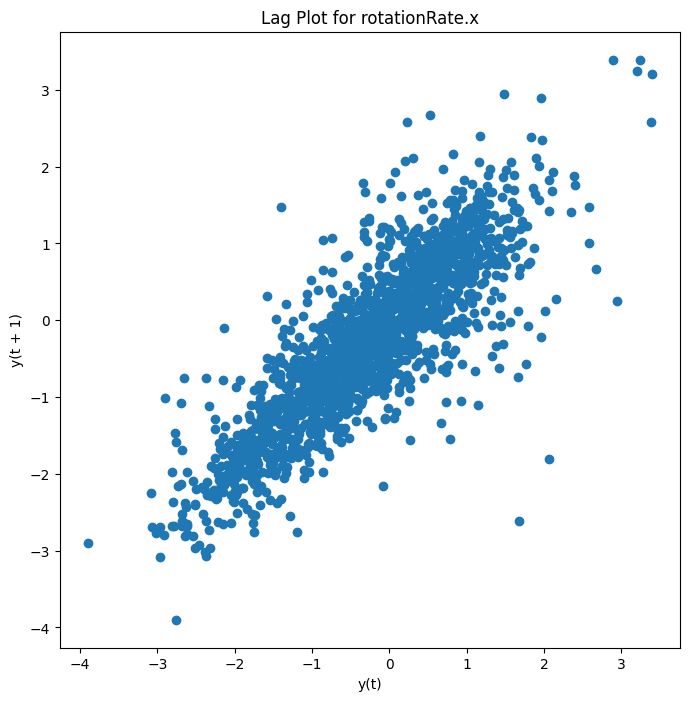

In [40]:
plt.figure(figsize=(8, 8))
lag_plot(sensor['rotationRate.x'])
plt.title("Lag Plot for rotationRate.x")
plt.show()

What are your conclusions from both visualizations?

In [ ]:
"""

both userAcceleration.x and rotationRate.x show some level of positive autocorrelation, with userAcceleration.x having a stronger relationship.
Neither plot suggests seasonality, and both have outliers that might need further investigation.
The rotationRate.x data appears to be more volatile with a weaker autocorrelation.

"""

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [44]:
adf_result_user_acceleration = adfuller(sensor['userAcceleration.x'])
print("Augmented Dickey-Fuller Test for userAcceleration.x:")
print("ADF Statistic:", adf_result_user_acceleration[0])
print("p-value:", adf_result_user_acceleration[1])
print("Critical Values:", adf_result_user_acceleration[4])

# Perform the Augmented Dickey-Fuller test for 'another_variable'
adf_result_another_variable = adfuller(sensor['rotationRate.x'])
print("\nAugmented Dickey-Fuller Test for another_variable:")
print("ADF Statistic:", adf_result_another_variable[0])
print("p-value:", adf_result_another_variable[1])
print("Critical Values:", adf_result_another_variable[4])

Augmented Dickey-Fuller Test for userAcceleration.x:
ADF Statistic: -17.957994086169762
p-value: 2.823439483037483e-30
Critical Values: {'1%': -3.434100824760071, '5%': -2.863196780129223, '10%': -2.5676520210882936}

Augmented Dickey-Fuller Test for another_variable:
ADF Statistic: -5.269860625086409
p-value: 6.320230335912605e-06
Critical Values: {'1%': -3.4341465551936534, '5%': -2.863216966926812, '10%': -2.567662770090317}


What are your conclusions from this test?

In [13]:
"""
The Augmented Dickey-Fuller test results for `userAcceleration.x` and `another_variable` indicate both time series are stationary, 
with ADF statistics significantly lower than the critical values and p-values below the 0.05 threshold.
This suggests that the data do not have a unit root and are not influenced by trends or seasonality.

"""

## Bonus: Challenge 2

Finally, we'll create an ARIMA model for `userAcceleration.x`. Load the `ARIMA` function from `statsmodels`. The order of the model is (2, 0, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [45]:
order = (2, 0, 1)

In [46]:
# 0. Splitting into train & test
y_train = sensor["userAcceleration.x"][:-10]
y_test = sensor["userAcceleration.x"][-11:]

In [49]:
# 1. Create an instance of the ARIMA model that takes y_train, the order, and freq="S"
# Docs: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html

model = ARIMA(y_train, order = (2,0,1), freq="S")

c:\Users\Felix\miniconda3\envs\ironhack\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)


In [51]:
model = ARIMA(y_train, order = (2,0,1), freq="S")
model = model.fit()
print(model.summary())

c:\Users\Felix\miniconda3\envs\ironhack\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     userAcceleration.x   No. Observations:                 1741
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 373.401
Date:                Tue, 14 Nov 2023   AIC                           -736.803
Time:                        16:44:22   BIC                           -709.492
Sample:                    01-01-2018   HQIC                          -726.704
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0637      0.016      3.994      0.000       0.032       0.095
ar.L1          0.9882      0.036     27.630      0.000       0.918       1.058
ar.L2         -0.3788      0.033    -11.637      0.0

In [52]:
sensor["forecasting_arima"] = model.predict(start=len(sensor['userAcceleration.x']) - 1000, end=len(sensor['userAcceleration.x']) +1000)
y_pred = sensor["forecasting_arima"]

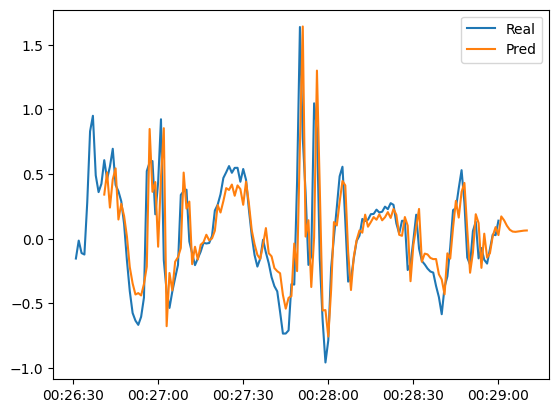

In [53]:
# 4. Visualize
plt.plot(y_train[-150:], label = "Real")
plt.plot(y_pred[-150:], label = "Pred")
plt.legend()

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [59]:
actual_values = sensor['userAcceleration.x'][-10:]
predicted_values = sensor['forecasting_arima'][-10:]

rmse_value = rmse(actual_values, predicted_values)

print("RMSE(Root Mean Squared Error):", rmse_value)

RMSE(Root Mean Squared Error): 0.22529160449986013
